<a href="https://colab.research.google.com/github/ashishthomaschempolil/Santander-Customer-Satisfaction/blob/master/Modelling_LogOHE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='muted',style='whitegrid')
import sklearn
from sklearn import metrics,ensemble,model_selection,linear_model,tree,calibration
import xgboost as xgb
import lightgbm as lgb
import scipy
import random
from tqdm import tqdm
import os
np.random.seed(13154)

In [2]:
file = [k for k in os.listdir('/content/drive/My Drive/Santander_Customer_Satisfaction') if (('train' in k)|('test' in k))&('X' not in k)] #getting all the necessary files for modelling
file

['train_Normal.pkl',
 'test_Normal.pkl',
 'train_Normal with Response encoding.pkl',
 'test_Normal with Response encoding.pkl',
 'train_Normal with One Hot Encoding.pkl',
 'test_Normal with One Hot Encoding.pkl',
 'train_Log Transformed.pkl',
 'test_Log Transformed.pkl',
 'train_Log Transformed with Response encoding.pkl',
 'test_Log Transformed with Response encoding.pkl',
 'train_Log Transformed with One Hot Encoding.pkl',
 'test_Log Transformed with One Hot Encoding.pkl']

In [3]:
file_path = '/content/drive/My Drive/Santander_Customer_Satisfaction/'
train_file = file_path+file[10] #log transformed
test_file = file_path+file[11]
dataset= "Log Transformed OHE"
train = pd.read_pickle(train_file)
test = pd.read_pickle(test_file)
X_train = train.drop(['ID','TARGET'],axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID',axis=1)
del train,test
X_train,X_val,y_train,y_val = model_selection.train_test_split(X_train,y_train,stratify=y_train,test_size=0.15)
X_train.shape,X_val.shape,X_test.shape

((64617, 445), (11403, 445), (75818, 445))

In [4]:
global i
i=0
def plot_auc(y_true,y_pred,label,dataset=dataset):
  """
  Plots auc curve when y_true and y_pred are given
  dataset is string which tells which dataset were used.
  label: tells which model was used
  If label is a list plots all the auc curve for all labels (here y_pred will be a list of lists )
  """
  
  
  if (type(label)!=list) & (type(label)!=np.array):
    print("\t\t %s on %s dataset \t\t \n"%(label,dataset))
    fpr,tpr,threshold = metrics.roc_curve(y_true,y_pred) #getting true positive rate, false positive rate
    auc = metrics.roc_auc_score(y_true,y_pred) #getting auc score
    log_loss = metrics.log_loss(y_true,y_pred) #getting logloss
    label_1 = label+' AUC=%.3f'%(auc)

    #plotting tpr vs fpr
    sns.lineplot(fpr,tpr,label=label_1)
    x=np.arange(0,1.1,0.1) #auc=0.5 line 
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("ROC on %s dataset"%(dataset))
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()
    print("The log loss and auc was found to be %.3f and %.3f for %s on %s dataset."%(log_loss,auc,label,dataset))
    #creating a dataframe of the result
    result_dict = {"Model":label,'Dataset':dataset,'log_loss':log_loss,'auc':auc}
    
    return pd.DataFrame(result_dict,index=[i])

  else:
    plt.figure(figsize=(12,8))
    for k,y in enumerate(y_pred):
      fpr,tpr,threshold = metrics.roc_curve(y_true,y)
      auc = metrics.roc_auc_score(y_true,y)
      label_ = label[k]+' AUC=%.3f'%(auc)
      #plotting tpr vs fpr
      sns.lineplot(fpr,tpr,label=label_)

    x=np.arange(0,1.1,0.1)
    sns.lineplot(x,x,label="AUC=0.5")
    plt.title("Combined ROC")
    plt.xlabel('False Positive Rate')
    plt.ylabel("True Positive Rate")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) #legend box outside graph
    plt.show()

In [5]:
def find_best_params(model,params,cv=10,n_jobs=-1,X_train=X_train):
  """
  Funcion which implements Random Seacrh CV and returns best model
  """
  random_cv = model_selection.RandomizedSearchCV(model,param_distributions=params,scoring='roc_auc',n_jobs=n_jobs,cv=cv,verbose=2)
  random_cv.fit(X_train,y_train)
  print("The best auc score was %.3f"%(random_cv.best_score_))
  print("The best params were: %s"%(random_cv.best_params_))
  return random_cv.best_estimator_

In [6]:
def plot_feature_importance(df,feat_imp,top=20,size=(6,6)):
    """
    getting most important top features if df and feature_importance array is passed
    """
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
    plt.figure(figsize=size)
    sns.barplot(x=feat_imp[top_indices],y=most_important_feat) #plotting feature importance 
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel("Feature names")
    plt.show()

In [7]:
def get_top_features(df,feat_imp,top=50):
  """
  gets the top features.
  if top is of integer dtype it will return top features,
  if top is between 0 and 1, it will return features that have at least feature importance value= top
  """
  if (top>0.)&(top<=1.): #getting the features that have feature importance value greater than top
    feature_to_consider = [1 if i>=top else 0 for i in feat_imp]
    most_important_feat = [i  for i,j in zip(df.columns,feature_to_consider) if (j==1)]#getiing the columns names
  else:
    top_indices = np.argsort(feat_imp)[::-1][:top] #getting the indices with top feature importace
    most_important_feat = df.columns[top_indices] #getiing the columns names
  return most_important_feat    

# Modeling

# Logistic Regression

In [ ]:
model = linear_model.LogisticRegression(class_weight='balanced')
params = {'penalty':['l2','l1'], 'C':[10.**i for i in np.arange(-3,3,1)], 
          'fit_intercept':[True,False] ,
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.2min finished


The best auc score was 0.812
The best params were: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.001}
CPU times: user 9.48 s, sys: 1.19 s, total: 10.7 s
Wall time: 4min 17s


LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
model = linear_model.LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train,y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

		 Logisic Regression on Log Transformed OHE dataset 		 



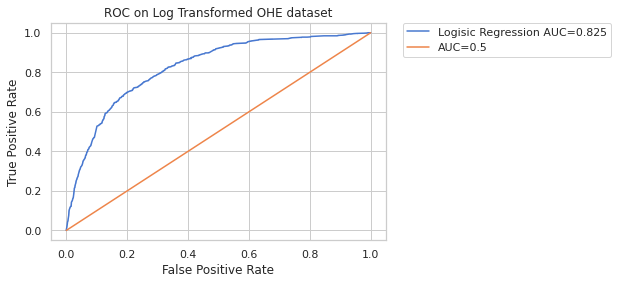

The log loss and auc was found to be 0.519 and 0.825 for Logisic Regression on Log Transformed OHE dataset.


In [9]:
labels=[] #storing all labels
y_preds = [] #storing all y_pred
y_pred = model.predict_proba(X_val)[:,1]
label="Logisic Regression"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result
del result

In [10]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808


# Decision Trees

In [ ]:
model = tree.DecisionTreeClassifier(class_weight='balanced')
params = { 
          'max_depth':[10,100,500,1000,-1], 
         'min_samples_split':[2,5,10,100,500], 
          'min_samples_leaf':[1,3,5,7,10],
          'max_leaf_nodes':[100,500,1000,5000,-1] 
          }


In [ ]:
%%time
find_best_params(model,params)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


The best auc score was 0.790
The best params were: {'min_samples_split': 500, 'min_samples_leaf': 1, 'max_leaf_nodes': 100, 'max_depth': 1000}
CPU times: user 5.43 s, sys: 237 ms, total: 5.67 s
Wall time: 6min 22s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [11]:
model = tree.DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                        splitter='best')

model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=1000, max_features=None, max_leaf_nodes=100,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [12]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features=None,
                                                             max_leaf_nodes=100,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=500,
                                                             min_weight_fraction_leaf=0.0,
                                                             presort='deprecated',
        

		 Decision Tree Classifier on Log Transformed OHE dataset 		 



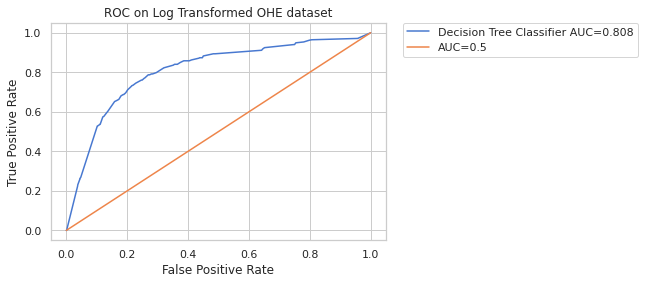

The log loss and auc was found to be 0.141 and 0.808 for Decision Tree Classifier on Log Transformed OHE dataset.


In [13]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Decision Tree Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [14]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160


# Random Forest

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 75.4min finished


The best auc score was 0.818
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 3min 27s, sys: 774 ms, total: 3min 28s
Wall time: 1h 18min 50s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

%time model.fit(X_train,y_train)

CPU times: user 5min 10s, sys: 1.21 s, total: 5min 11s
Wall time: 2min 38s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [16]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier on Log Transformed OHE dataset 		 



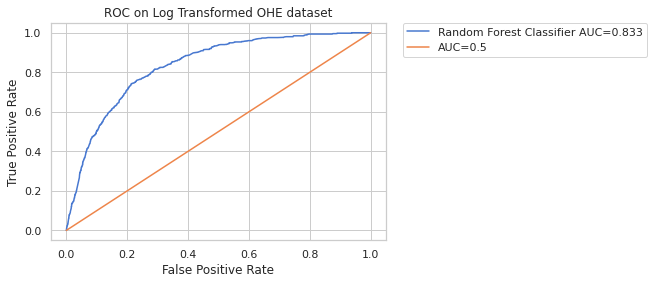

The log loss and auc was found to be 0.137 and 0.833 for Random Forest Classifier on Log Transformed OHE dataset.


In [17]:
i+=1
y_pred = cc_model.predict_proba(X_val)[:,1]
label="Random Forest Classifier"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [18]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430


# Selecting top features

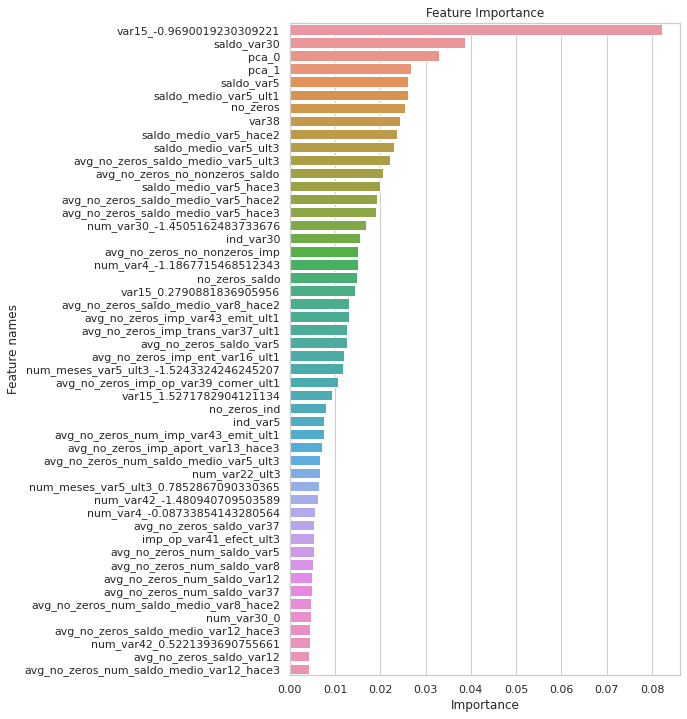

In [19]:
plot_feature_importance(X_train,model.feature_importances_,top=50,size=(7,12))

We will create new datasets with less features.

In [20]:
#getting features that have >=0.01 feature importance value.
top=0.01
features = get_top_features(X_train,model.feature_importances_,top=top)
print("There are %i features that have feature importance value above %.5f"%(len(features),top))
X_train_01 = X_train[features].copy()
X_val_01 = X_val[features].copy()
X_test_01 = X_val[features].copy()

There are 28 features that have feature importance value above 0.01000


In [21]:
#getting top k features
top=100
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_100 = X_train[features].copy()
X_val_100 = X_val[features].copy()
X_test_100 = X_val[features].copy()

Taking top 100 features


In [22]:
#getting top k features
top=250
features = get_top_features(X_train,model.feature_importances_,top=top)
print("Taking top %i features"%(top))
X_train_200 = X_train[features].copy()
X_val_200 = X_val[features].copy()
X_test_200 = X_val[features].copy()

Taking top 250 features


# XGB Classifier

In [23]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.7,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.,
                      max_depth=5,
                     )
#validation_0-auc:0.84753

In [24]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.799099	validation_0-error:0.039463
[1]	validation_0-auc:0.81073	validation_0-error:0.039551
[2]	validation_0-auc:0.81713	validation_0-error:0.039551
[3]	validation_0-auc:0.819069	validation_0-error:0.039551
[4]	validation_0-auc:0.820941	validation_0-error:0.039551
[5]	validation_0-auc:0.823237	validation_0-error:0.039551
[6]	validation_0-auc:0.822279	validation_0-error:0.039551
[7]	validation_0-auc:0.821473	validation_0-error:0.039551
[8]	validation_0-auc:0.821328	validation_0-error:0.039551
[9]	validation_0-auc:0.820656	validation_0-error:0.039551
[10]	validation_0-auc:0.821111	validation_0-error:0.039551
[11]	validation_0-auc:0.820569	validation_0-error:0.039551
[12]	validation_0-auc:0.821881	validation_0-error:0.039551
[13]	validation_0-auc:0.821744	validation_0-error:0.039551
[14]	validation_0-auc:0.822172	validation_0-error:0.039551
[15]	validation_0-auc:0.822463	validation_0-error:0.039551
[16]	validation_0-auc:0.823381	validation_0-error:0.039551
[17]	vali

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

		 XGBoost Classifer on Log Transformed OHE dataset 		 



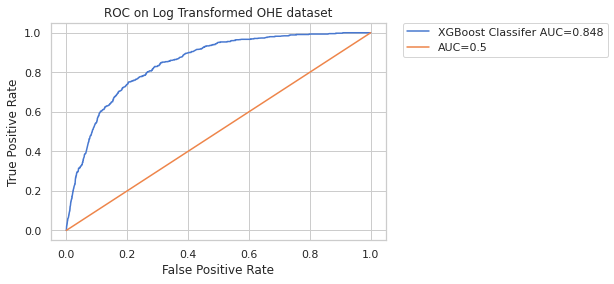

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer on Log Transformed OHE dataset.


In [25]:
y_pred = model.predict_proba(X_val)[:,1]
label="XGBoost Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [26]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530


# LightGBM Classifier

In [27]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=375,
                      reg_alpha = 0.4,
                      max_depth=7
                     )


In [28]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train,y_train,eval_set=[(X_val,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165269	valid_0's auc: 0.773588
[2]	valid_0's binary_logloss: 0.163814	valid_0's auc: 0.819022
[3]	valid_0's binary_logloss: 0.162668	valid_0's auc: 0.815531
[4]	valid_0's binary_logloss: 0.161596	valid_0's auc: 0.822651
[5]	valid_0's binary_logloss: 0.160412	valid_0's auc: 0.827094
[6]	valid_0's binary_logloss: 0.159439	valid_0's auc: 0.826677
[7]	valid_0's binary_logloss: 0.158639	valid_0's auc: 0.825928
[8]	valid_0's binary_logloss: 0.157836	valid_0's auc: 0.823918
[9]	valid_0's binary_logloss: 0.156977	valid_0's auc: 0.826513
[10]	valid_0's binary_logloss: 0.156152	valid_0's auc: 0.829501
[11]	valid_0's binary_logloss: 0.155326	valid_0's auc: 0.832095
[12]	valid_0's binary_logloss: 0.154609	valid_0's auc: 0.832627
[13]	valid_0's binary_logloss: 0.153875	valid_0's auc: 0.833742
[14]	valid_0's binary_logloss: 0.153165	valid_0's auc: 0.835582
[15]	valid_0's binary_logloss: 0.152666	valid_0's auc: 0.834754
[16]	valid_0's binary_logloss: 0.152041	valid_0's

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.02, max_depth=7,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=375, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer on Log Transformed OHE dataset 		 



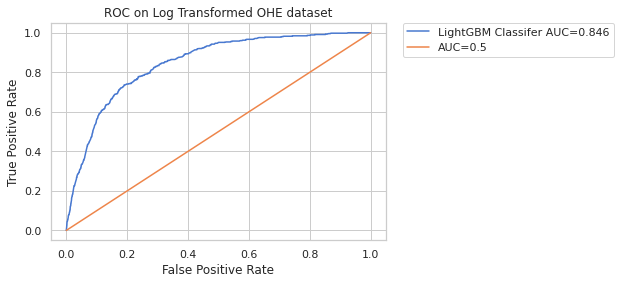

The log loss and auc was found to be 0.133 and 0.846 for LightGBM Classifer on Log Transformed OHE dataset.


In [29]:
y_pred = model.predict_proba(X_val)[:,1]
label="LightGBM Classifer"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [30]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485


# Random Forest (feature importance>0.01)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_01)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 39.6min finished


The best auc score was 0.820
The best params were: {'n_estimators': 2000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 500}
CPU times: user 3min, sys: 561 ms, total: 3min
Wall time: 42min 39s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False,
                       verbose=0, warm_start=False)

model.fit(X_train_01,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2000, max_features='auto',
                       max_leaf_nodes=100, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=7, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [32]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_01,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=2000,
                                                             max_features='auto',
                                                             max_leaf_nodes=100,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=7,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (feature importance>0.01) on Log Transformed OHE dataset 		 



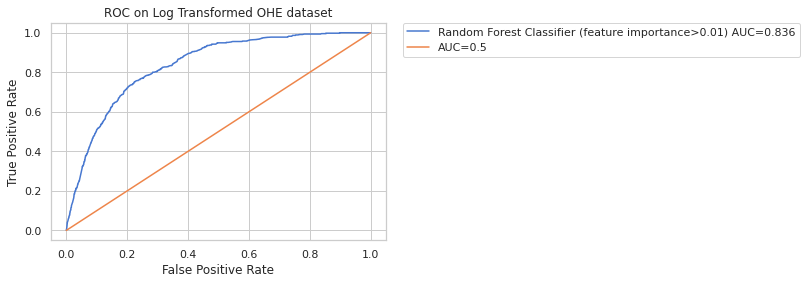

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (feature importance>0.01) on Log Transformed OHE dataset.


In [33]:
i+=1
y_pred = cc_model.predict_proba(X_val_01)[:,1]
label="Random Forest Classifier (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [34]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518


# XGB Classifier (feature importance>0.01)

In [35]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.02,  
                      colsample_bytree = 0.8,
                      subsample = 0.9,
                      objective='binary:logistic', 
                      n_estimators=500,
                      reg_alpha = 0.3,
                      max_depth=5, 
                     )


In [36]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.816944	validation_0-error:0.039551
[1]	validation_0-auc:0.817571	validation_0-error:0.039551
[2]	validation_0-auc:0.816857	validation_0-error:0.039551
[3]	validation_0-auc:0.819369	validation_0-error:0.039551
[4]	validation_0-auc:0.824715	validation_0-error:0.039551
[5]	validation_0-auc:0.827306	validation_0-error:0.039551
[6]	validation_0-auc:0.826954	validation_0-error:0.039551
[7]	validation_0-auc:0.826835	validation_0-error:0.039551
[8]	validation_0-auc:0.827633	validation_0-error:0.039551
[9]	validation_0-auc:0.826238	validation_0-error:0.039551
[10]	validation_0-auc:0.824599	validation_0-error:0.039551
[11]	validation_0-auc:0.825027	validation_0-error:0.039551
[12]	validation_0-auc:0.824976	validation_0-error:0.039551
[13]	validation_0-auc:0.825981	validation_0-error:0.039551
[14]	validation_0-auc:0.825882	validation_0-error:0.039551
[15]	validation_0-auc:0.827066	validation_0-error:0.039551
[16]	validation_0-auc:0.826736	validation_0-error:0.039551
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0.3, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=1)

		 XGBoost Classifer(feature importance>0.01) on Log Transformed OHE dataset 		 



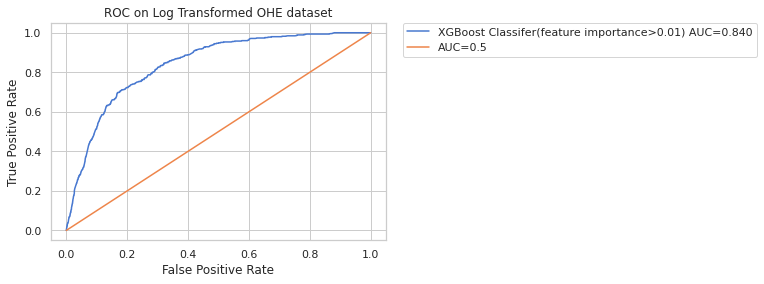

The log loss and auc was found to be 0.135 and 0.840 for XGBoost Classifer(feature importance>0.01) on Log Transformed OHE dataset.


In [37]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="XGBoost Classifer(feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [38]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220


# LightGBM Classifier (feature importance>0.01)

In [39]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.7,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=740,
                      reg_alpha = 0.3,
                      max_depth=7, 
                      gamma=5
                     )

In [40]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_01,y_train,eval_set=[(X_val_01,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165889	valid_0's auc: 0.784715
[2]	valid_0's binary_logloss: 0.165257	valid_0's auc: 0.797503
[3]	valid_0's binary_logloss: 0.16455	valid_0's auc: 0.820265
[4]	valid_0's binary_logloss: 0.163968	valid_0's auc: 0.815247
[5]	valid_0's binary_logloss: 0.163347	valid_0's auc: 0.821359
[6]	valid_0's binary_logloss: 0.162743	valid_0's auc: 0.825541
[7]	valid_0's binary_logloss: 0.162246	valid_0's auc: 0.822664
[8]	valid_0's binary_logloss: 0.161738	valid_0's auc: 0.821997
[9]	valid_0's binary_logloss: 0.16115	valid_0's auc: 0.825562
[10]	valid_0's binary_logloss: 0.160614	valid_0's auc: 0.827806
[11]	valid_0's binary_logloss: 0.160116	valid_0's auc: 0.828663
[12]	valid_0's binary_logloss: 0.159662	valid_0's auc: 0.829429
[13]	valid_0's binary_logloss: 0.159157	valid_0's auc: 0.830169
[14]	valid_0's binary_logloss: 0.15873	valid_0's auc: 0.829945
[15]	valid_0's binary_logloss: 0.158283	valid_0's auc: 0.830916
[16]	valid_0's binary_logloss: 0.157802	valid_0's au

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               gamma=5, importance_type='split', learning_rate=0.01,
               max_depth=7, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=740, n_jobs=-1, nthread=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.3, reg_lambda=0.0, scale_pos_weight=1, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer (feature importance>0.01) on Log Transformed OHE dataset 		 



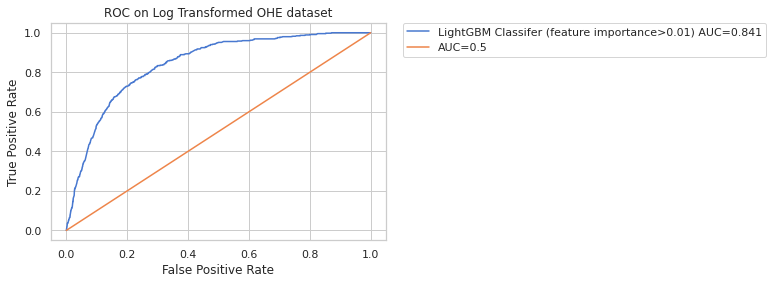

The log loss and auc was found to be 0.135 and 0.841 for LightGBM Classifer (feature importance>0.01) on Log Transformed OHE dataset.


In [41]:
y_pred = model.predict_proba(X_val_01)[:,1]
label="LightGBM Classifer (feature importance>0.01)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [42]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443


# Random Forest (top 100)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_100)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 42.1min finished


The best auc score was 0.823
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 5, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 12s, sys: 446 ms, total: 2min 13s
Wall time: 44min 17s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [43]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_100,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=1000, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [44]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_100,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=1000,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=5,
                                                             min_samples_split=500,
                        

		 Random Forest Classifier (top 100) on Log Transformed OHE dataset 		 



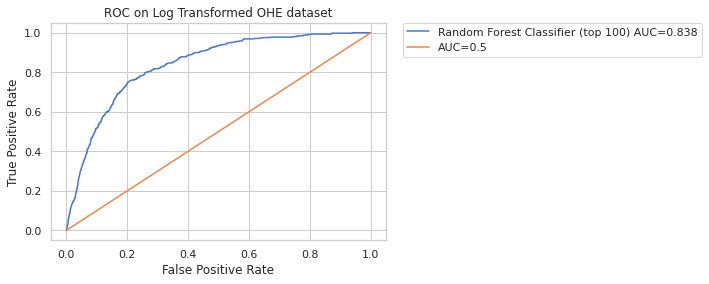

The log loss and auc was found to be 0.136 and 0.838 for Random Forest Classifier (top 100) on Log Transformed OHE dataset.


In [45]:
i+=1
y_pred = cc_model.predict_proba(X_val_100)[:,1]
label="Random Forest Classifier (top 100)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [46]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089


# XGB Classifier (top 100)

In [47]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 1,
                      max_depth=5,
                     )


In [48]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.814141	validation_0-error:0.039551
[1]	validation_0-auc:0.816903	validation_0-error:0.039551
[2]	validation_0-auc:0.8197	validation_0-error:0.039551
[3]	validation_0-auc:0.821422	validation_0-error:0.039551
[4]	validation_0-auc:0.82088	validation_0-error:0.039551
[5]	validation_0-auc:0.821506	validation_0-error:0.039551
[6]	validation_0-auc:0.824134	validation_0-error:0.039551
[7]	validation_0-auc:0.823903	validation_0-error:0.039551
[8]	validation_0-auc:0.820992	validation_0-error:0.039551
[9]	validation_0-auc:0.820523	validation_0-error:0.039551
[10]	validation_0-auc:0.818736	validation_0-error:0.039551
[11]	validation_0-auc:0.816275	validation_0-error:0.039551
[12]	validation_0-auc:0.817209	validation_0-error:0.039551
[13]	validation_0-auc:0.817071	validation_0-error:0.039551
[14]	validation_0-auc:0.816959	validation_0-error:0.039551
[15]	validation_0-auc:0.816373	validation_0-error:0.039551
[16]	validation_0-auc:0.816229	validation_0-error:0.039551
[17]	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

		 XGBoost Classifer(top 100) on Log Transformed OHE dataset 		 



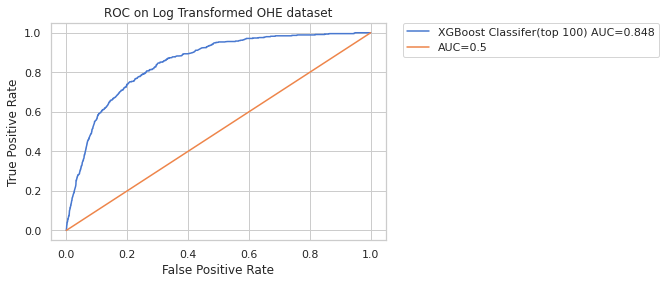

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer(top 100) on Log Transformed OHE dataset.


In [49]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="XGBoost Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [50]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132715,0.847948


# LightGBM Classifier (top 100)

In [51]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='binary', 
                      n_estimators=947,
                      reg_alpha = 0.4,
                      max_depth=5 
                     )


In [52]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_100,y_train,eval_set=[(X_val_100,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.16592	valid_0's auc: 0.795592
[2]	valid_0's binary_logloss: 0.165333	valid_0's auc: 0.798801
[3]	valid_0's binary_logloss: 0.164734	valid_0's auc: 0.80834
[4]	valid_0's binary_logloss: 0.164059	valid_0's auc: 0.821921
[5]	valid_0's binary_logloss: 0.163481	valid_0's auc: 0.822957
[6]	valid_0's binary_logloss: 0.162924	valid_0's auc: 0.82503
[7]	valid_0's binary_logloss: 0.162353	valid_0's auc: 0.826002
[8]	valid_0's binary_logloss: 0.161835	valid_0's auc: 0.826599
[9]	valid_0's binary_logloss: 0.161344	valid_0's auc: 0.82681
[10]	valid_0's binary_logloss: 0.160935	valid_0's auc: 0.824778
[11]	valid_0's binary_logloss: 0.160533	valid_0's auc: 0.824661
[12]	valid_0's binary_logloss: 0.160079	valid_0's auc: 0.82507
[13]	valid_0's binary_logloss: 0.159594	valid_0's auc: 0.82688
[14]	valid_0's binary_logloss: 0.159211	valid_0's auc: 0.82654
[15]	valid_0's binary_logloss: 0.158767	valid_0's auc: 0.828559
[16]	valid_0's binary_logloss: 0.158337	valid_0's auc: 0

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=5,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=947, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0.4,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 100) on Log Transformed OHE dataset 		 



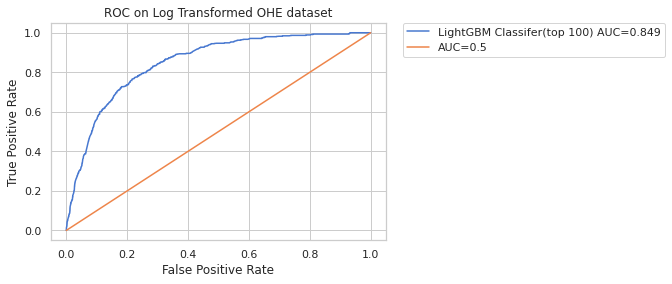

The log loss and auc was found to be 0.132 and 0.849 for LightGBM Classifer(top 100) on Log Transformed OHE dataset.


In [53]:
y_pred = model.predict_proba(X_val_100)[:,1]
label="LightGBM Classifer(top 100)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [54]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132715,0.847948


# Random Forest (top 250)

In [ ]:
model = ensemble.RandomForestClassifier(class_weight='balanced')
params = { 'n_estimators':[1000,2000],
          'max_depth':[500,1000], 
         'min_samples_split':[100,500],
          'min_samples_leaf':[3,5],
          'max_leaf_nodes':[100,250] 
          }


In [ ]:
%%time
find_best_params(model,params,cv=3,X_train=X_train_200)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 54.4min finished


The best auc score was 0.820
The best params were: {'n_estimators': 1000, 'min_samples_split': 500, 'min_samples_leaf': 3, 'max_leaf_nodes': 250, 'max_depth': 500}
CPU times: user 2min 58s, sys: 552 ms, total: 2min 58s
Wall time: 57min 23s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [55]:
model = ensemble.RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

model.fit(X_train_200,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=500, max_features='auto',
                       max_leaf_nodes=250, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [56]:
cc_model = calibration.CalibratedClassifierCV(model,cv='prefit')
cc_model.fit(X_train_200,y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             ccp_alpha=0.0,
                                                             class_weight='balanced',
                                                             criterion='gini',
                                                             max_depth=500,
                                                             max_features='auto',
                                                             max_leaf_nodes=250,
                                                             max_samples=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=3,
                                                             min_samples_split=500,
                         

		 Random Forest Classifier (top 250) on Log Transformed OHE dataset 		 



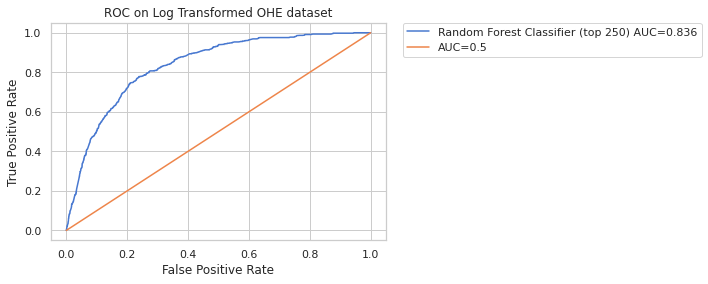

The log loss and auc was found to be 0.137 and 0.836 for Random Forest Classifier (top 250) on Log Transformed OHE dataset.


In [57]:
i+=1
y_pred = cc_model.predict_proba(X_val_200)[:,1]
label="Random Forest Classifier (top 250)"
labels.append(label)
y_preds.append(y_pred)
result = plot_auc(y_val,y_pred,label,dataset)
result_df = result_df.append(result)
del result

In [58]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132715,0.847948


# XGB Classifier (top 250)

In [59]:
model = xgb.XGBClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.8, 
                      subsample = 0.7,
                      objective='binary:logistic', 
                      n_estimators=845,
                      reg_alpha = 0,
                      max_depth=6, 
                     )

In [60]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[0]	validation_0-auc:0.793855	validation_0-error:0.039989
[1]	validation_0-auc:0.808414	validation_0-error:0.039989
[2]	validation_0-auc:0.821636	validation_0-error:0.039726
[3]	validation_0-auc:0.825153	validation_0-error:0.039639
[4]	validation_0-auc:0.825033	validation_0-error:0.039639
[5]	validation_0-auc:0.82554	validation_0-error:0.039639
[6]	validation_0-auc:0.827218	validation_0-error:0.039639
[7]	validation_0-auc:0.827203	validation_0-error:0.039639
[8]	validation_0-auc:0.827309	validation_0-error:0.039639
[9]	validation_0-auc:0.828029	validation_0-error:0.039639
[10]	validation_0-auc:0.828076	validation_0-error:0.039551
[11]	validation_0-auc:0.828619	validation_0-error:0.039551
[12]	validation_0-auc:0.829181	validation_0-error:0.039551
[13]	validation_0-auc:0.828946	validation_0-error:0.039551
[14]	validation_0-auc:0.829032	validation_0-error:0.039551
[15]	validation_0-auc:0.829184	validation_0-error:0.039551
[16]	validation_0-auc:0.829254	validation_0-error:0.039551
[17]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=845, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.7, verbosity=1)

		 XGBoost Classifer(top 250) on Log Transformed OHE dataset 		 



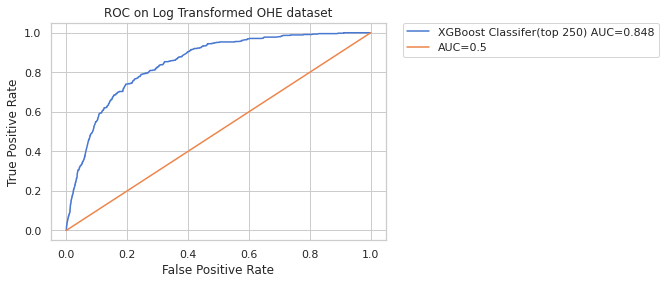

The log loss and auc was found to be 0.133 and 0.848 for XGBoost Classifer(top 250) on Log Transformed OHE dataset.


In [61]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="XGBoost Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

In [62]:
result_df

,Model,Dataset,log_loss,auc
0,Logisic Regression,Log Transformed OHE,0.518675,0.824808
1,Decision Tree Classifier,Log Transformed OHE,0.140647,0.808160
2,Random Forest Classifier,Log Transformed OHE,0.137261,0.833430
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132715,0.847948


# LightGBM Classifier (top 250)

In [63]:
model = lgb.LGBMClassifier(n_jobs=-1,
                      nthread=-1,
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.5,
                      subsample = .8,
                      objective='binary', 
                      n_estimators=447,
                      reg_alpha = 0,
                      max_depth=8,
                     )

In [64]:
#https://towardsdatascience.com/fine-tuning-xgboost-in-python-like-a-boss-b4543ed8b1e
"""
manually changed each parameters 1 by 1 and compared the validation auc
and selected the best parameter value
"""
eval_metric = ['auc','error']
%time model.fit(X_train_200,y_train,eval_set=[(X_val_200,y_val)],eval_metric=eval_metric,verbose=True)

[1]	valid_0's binary_logloss: 0.165859	valid_0's auc: 0.80076
[2]	valid_0's binary_logloss: 0.165083	valid_0's auc: 0.826886
[3]	valid_0's binary_logloss: 0.164441	valid_0's auc: 0.827136
[4]	valid_0's binary_logloss: 0.163791	valid_0's auc: 0.833633
[5]	valid_0's binary_logloss: 0.163224	valid_0's auc: 0.831763
[6]	valid_0's binary_logloss: 0.162675	valid_0's auc: 0.831492
[7]	valid_0's binary_logloss: 0.16211	valid_0's auc: 0.832107
[8]	valid_0's binary_logloss: 0.161538	valid_0's auc: 0.833962
[9]	valid_0's binary_logloss: 0.160978	valid_0's auc: 0.833779
[10]	valid_0's binary_logloss: 0.16045	valid_0's auc: 0.83295
[11]	valid_0's binary_logloss: 0.15993	valid_0's auc: 0.833867
[12]	valid_0's binary_logloss: 0.159447	valid_0's auc: 0.833886
[13]	valid_0's binary_logloss: 0.158923	valid_0's auc: 0.834032
[14]	valid_0's binary_logloss: 0.158451	valid_0's auc: 0.835173
[15]	valid_0's binary_logloss: 0.157987	valid_0's auc: 0.835923
[16]	valid_0's binary_logloss: 0.157501	valid_0's auc:

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', learning_rate=0.01, max_depth=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=447, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=None, reg_alpha=0,
               reg_lambda=0.0, scale_pos_weight=1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

		 LightGBM Classifer(top 250) on Log Transformed OHE dataset 		 



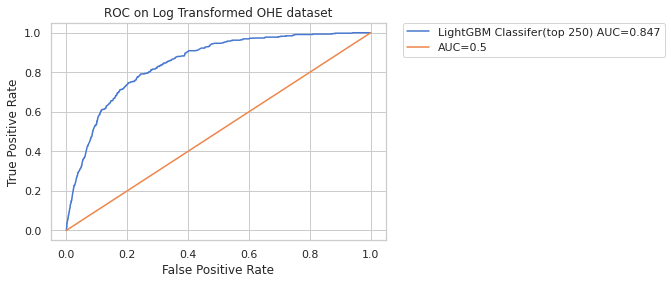

The log loss and auc was found to be 0.133 and 0.847 for LightGBM Classifer(top 250) on Log Transformed OHE dataset.


In [65]:
y_pred = model.predict_proba(X_val_200)[:,1]
label="LightGBM Classifer(top 250)"
labels.append(label)
y_preds.append(y_pred)
i+=1
result = plot_auc(y_val,y_pred,label)
result_df = result_df.append(result)
del result

# Combined

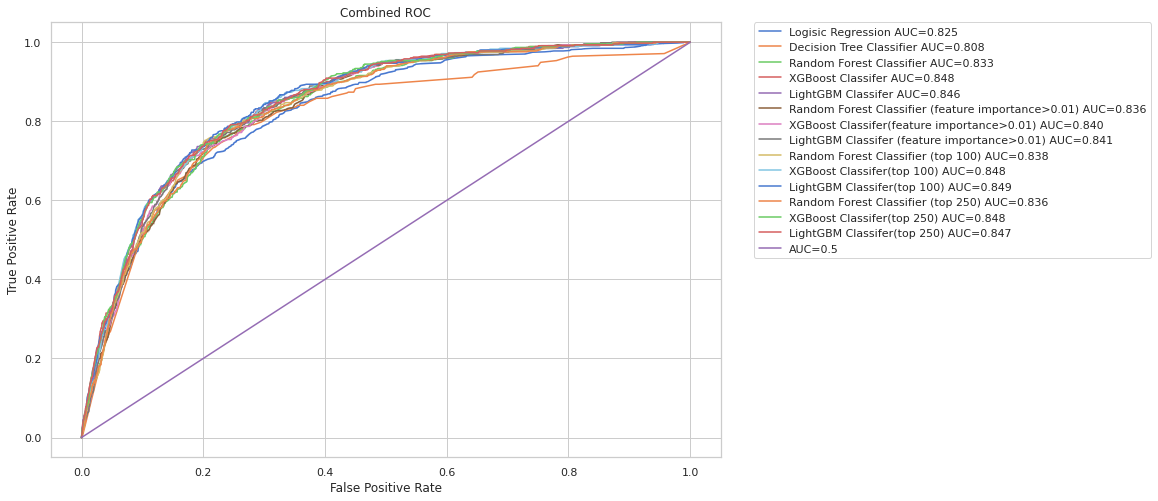

In [66]:
plot_auc(y_val,y_preds,labels)

In [67]:
result_df.sort_values(by='log_loss')

,Model,Dataset,log_loss,auc
10,LightGBM Classifer(top 100),Log Transformed OHE,0.132232,0.849388
12,XGBoost Classifer(top 250),Log Transformed OHE,0.132658,0.847651
3,XGBoost Classifer,Log Transformed OHE,0.132711,0.847530
9,XGBoost Classifer(top 100),Log Transformed OHE,0.132715,0.847948
4,LightGBM Classifer,Log Transformed OHE,0.132820,0.846485
13,LightGBM Classifer(top 250),Log Transformed OHE,0.133081,0.846910
7,LightGBM Classifer (feature importance>0.01),Log Transformed OHE,0.134616,0.841443
6,XGBoost Classifer(feature importance>0.01),Log Transformed OHE,0.134805,0.840220
8,Random Forest Classifier (top 100),Log Transformed OHE,0.135940,0.838089
5,Random Forest Classifier (feature importance>0...,Log Transformed OHE,0.136718,0.835518
